# Machine Learning in Cyber Security LAB3 

**zz3230 Zhe ZHANG**

## Prework

**Import Libraries**

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt

**File routes**

In [2]:
### data_file
clean_test_file = './data/cl/test.h5'
clean_valid_file = './data/cl/valid.h5'
bad_test_file = './data/bd/bd_test.h5'
bad_valid_file = './data/bd/bd_valid.h5'

### model_file
bad_net_file = './models/bd_net.h5'
bad_net_weights = './models/bd_weights.h5'

In [3]:
if os.path.isdir('./result')== False:
    os.mkdir('./result')

**data loader**

In [4]:
### Load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    #x_data = data_preprocess(x_data)
    print(filepath + " loaded")
    return x_data, y_data

**data processor**

In [5]:
def data_preprocess(x_data):
    return x_data/255

**net loader**

In [6]:
### Load net model & weights
def net_loader(net_file):
    badNet = keras.models.load_model(net_file)
    print("model " + net_file + " loaded")

    return badNet

**network weights loader**

In [7]:
def weights_loader(self, weights_file):
    self.load_weights(weights_file)
    print("weights " + weights_file + " for " + \
          "model " + net_file + " loaded")
    return self

**evaluate backdoored network performance**

In [8]:
def eval_origin(bd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
    
    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    attack_rate = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', attack_rate)
    return clean_accuracy

In [9]:
X_clean_valid, y_clean_valid = data_loader(clean_valid_file)
X_bad_valid, y_bad_valid = data_loader(bad_valid_file)

./data/cl/valid.h5 loaded
./data/bd/bd_valid.h5 loaded


In [10]:
bd_model = net_loader(bad_net_file)
origin_acc = eval_origin(bd_model, X_clean_valid, y_clean_valid, X_bad_valid, y_bad_valid)

model ./models/bd_net.h5 loaded
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


## Prune Channels

You will design G using the pruning defense that we discussed in class. That is, you will prune
the last pooling layer of BadNet B (the layer just before the FC layers) by removing one
channel at a time from that layer. Channels should be removed in decreasing order of average
activation values over the entire validation set. Every time you prune a channel, you will
measure the new validation accuracy of the new pruned badnet. You will stop pruning once the
validation accuracy drops atleast X% below the original accuracy. This will be your new
network B'

**show the structure of bd_net**

In [11]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

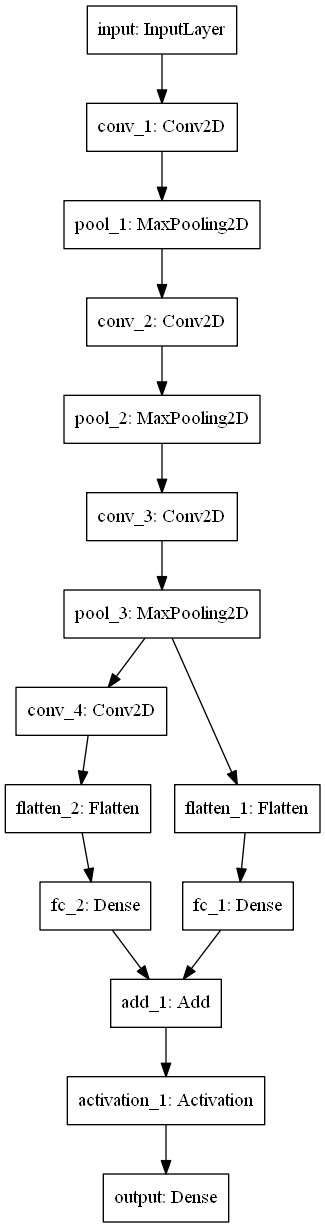

In [12]:
keras.utils.plot_model(bd_model)

The specific layer we would prune is the Conv2D layer named 'conv_3'

**Copy the backdoored model and find the specific layer to prune**

load network and weights

In [13]:
prune_model = keras.models.clone_model(bd_model)
prune_model.load_weights(bad_net_weights)

prune the last pooling layer of BadNet B (the layer just before the FC layers) by removing one
channel at a time from that layer. Channels should be removed in **increasing order** of average
activation values over the entire validation set. 

In [14]:
activation_output = prune_model.layers[6].output
avg_activation = np.mean(keras.models.Model(inputs=prune_model.input, outputs=activation_output).predict(X_clean_valid),axis=(0,1,2))
sorted_avg_act_channel = np.argsort(avg_activation)

show the increasing order of activation values

In [15]:
print("Increasing order of average activation values")
print(avg_activation[sorted_avg_act_channel])

Increasing order of average activation values
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.0290761e-03 6.2408661e-03 1.3321567e-02 1.5006668e-02
 4.3979675e-02 8.3539173e-02 1.8378231e-01 2.4381575e-01 4.2763174e-01
 5.0732863e-01 5.3079778e-01 5.7658589e-01 8.5787797e-01 1.0589781e+00
 1.5654888e+00 1.6352932e+00 1.8540378e+00 2.0289588e+00 2.1106052e+00
 2.1980376e+00 3.6191154e+00 4.1488924e+00 4.8440871e+00 4.8648086e+00
 5.0868411e+00 5.1451392e+00 5.3690357e+00 6.2038713e+00 8.2229824e+00]


Every time you prune a channel, you will
measure the new validation accuracy of the new pruned badnet. You will stop pruning once the
validation accuracy drops **atleast X% below the original accuracy**.

In [16]:
print("The original accuracy is  " + str(origin_acc))

The original accuracy is  98.64899974019225


In [17]:
X = np.array([2,4,10,30])

We are going to prune the channels, which means set the $W_h$ and $b_h$ to be 0 in each single channel of the **"conv_3"** layer

**Prune Channel in increasing order**

In [18]:
def prune_channel(prune_model,X,X_clean_valid,y_clean_valid,X_bad_valid,y_bad_valid,save=False):
    
    W_h = prune_model.layers[5].get_weights()[0]
    b_h = prune_model.layers[5].get_weights()[1]
    
    acc_ori = np.mean(np.equal(np.argmax(prune_model.predict(X_clean_valid), axis=1), y_clean_valid))*100
    atk_ori = np.mean(np.equal(np.argmax(prune_model.predict(X_bad_valid), axis=1), y_bad_valid))*100
    
    acc = []
    atk = []
    acc_tmp = 0
    atk_tmp = 0
    
    status = np.zeros(len(X))
    prune_num = np.zeros(len(X))
    
    for i in range(len(sorted_avg_act_channel)):
        
        ch = sorted_avg_act_channel[i]
        
        ### set and update w_h, b_h
        W_h[:,:,:,ch] = 0
        b_h[ch] = 0
        prune_model.layers[5].set_weights([W_h,b_h])
        
        ### predict and get the acc of the new network
        if abs(avg_activation[ch] - 0) < 0.0000001:
            acc_tmp = acc_ori
            atk_tmp = atk_ori
        else:
            acc_tmp = np.mean(np.equal(np.argmax(prune_model.predict(X_clean_valid), axis=1), y_clean_valid))*100
            atk_tmp = np.mean(np.equal(np.argmax(prune_model.predict(X_bad_valid), axis=1), y_bad_valid))*100
            
        acc.append(acc_tmp)
        atk.append(atk_tmp)
        print(str(i+1)+' channels pruned, acc = '+str(acc_tmp)+', atk = '+str(atk_tmp)+'， X = '+ str(acc_ori - acc_tmp))
        
        ### test and save the model if acc is X below the orignal acc
        if save == True:
            for j in range(len(X)):
                if acc_ori - acc_tmp > X[j] and status[j] == 0:
                    status[j] = 1
                    prune_num[j] = i+1
                    prune_model.save('./result/'+'pruning_channel_model_acc_decrease_by_'+str(X[j])+'%.h5')
                    print('pruning channel model accuracy decrease by '+str(X[j])+' saved at prune channels of '+str( prune_num[j]))

        keras.backend.clear_session()
        
    return acc, atk, prune_num
        

In [19]:
acc, atk, prune_num = prune_channel(prune_model,X,X_clean_valid,y_clean_valid,X_bad_valid,y_bad_valid,save=True)

1 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
2 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
3 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
4 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
5 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
6 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
7 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
8 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
9 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
10 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
11 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
12 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
13 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
14 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
15 channels pruned, acc = 98.64899974019225, atk = 100.0， X = 0.0
16 channels pruned,

## Good Network

What you must output is ​G ​a “repaired” BadNet. ​G​ has N+1 classes, and given unseen test
input, it must:

1. Output the correct class if the test input is clean. The correct class will be in [1,N].
2. Output class N+1 if the input is backdoored

For each test input, you will run it through both B and
B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you
will output N+1

**Generate good network**

In [20]:
class good_network(keras.Model):
    
    def __init__(self, B, B_pruned):
        super(good_network,self).__init__()
        self.B = B
        self.B_pruned = B_pruned
         
    def predict(self, X):
        yhat = np.argmax(self.B.predict(X),axis=1)
        yhat_pruned = np.argmax(self.B_pruned.predict(X),axis=1)
        yhat[np.where(yhat!=yhat_pruned)] = 1283
        
        return yhat

Combine network $B$ and network $B^{'}$ to be the repaired network $G$

In [21]:
repaired_model_2p = good_network(bd_model, net_loader('./result/pruning_channel_model_acc_decrease_by_2%.h5'))
repaired_model_4p = good_network(bd_model, net_loader('./result/pruning_channel_model_acc_decrease_by_4%.h5'))
repaired_model_10p = good_network(bd_model, net_loader('./result/pruning_channel_model_acc_decrease_by_10%.h5'))
repaired_model_30p = good_network(bd_model, net_loader('./result/pruning_channel_model_acc_decrease_by_30%.h5'))

model ./result/pruning_channel_model_acc_decrease_by_2%.h5 loaded
model ./result/pruning_channel_model_acc_decrease_by_4%.h5 loaded
model ./result/pruning_channel_model_acc_decrease_by_10%.h5 loaded
model ./result/pruning_channel_model_acc_decrease_by_30%.h5 loaded


## Evaluation

**However, the repaired network G is not a complete model but does have ability to classify**, SO, **we rewrite the eval.py function here**

Evaluation function for good network

In [22]:
def eval_repaired(model, X_clean_test,y_clean_test,X_bad_test,y_bad_test):
    cl_label_p = model.predict(X_clean_test)
    clean_accuracy = np.mean(np.equal(cl_label_p, y_clean_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = model.predict(X_bad_test)
    attack_rate = np.mean(np.equal(bd_label_p, y_bad_test))*100
    #print(bd_label_p)
    #print(y_bad_test)
    print('Attack Success Rate:', attack_rate)
    return clean_accuracy

load test data

In [23]:
X_clean_test, y_clean_test = data_loader(clean_test_file)
X_bad_test, y_bad_test = data_loader(bad_test_file)

./data/cl/test.h5 loaded
./data/bd/bd_test.h5 loaded


We will compare the performance among **original backdoored network** and **repaired networks**

In [24]:
print("backdoored network on test dataset")
eval_origin(bd_model, X_clean_test,y_clean_test,X_bad_test,y_bad_test)
print("repaired network, channels pruned with a 2% drop of accuracy, on test dataset")
eval_repaired(repaired_model_2p, X_clean_test,y_clean_test,X_bad_test,y_bad_test)
print("repaired network, channels pruned with a 4% drop of accuracy, on test dataset")
eval_repaired(repaired_model_4p, X_clean_test,y_clean_test,X_bad_test,y_bad_test)
print("repaired network, channels pruned with a 10% drop of accuracy, on test dataset")
eval_repaired(repaired_model_10p, X_clean_test,y_clean_test,X_bad_test,y_bad_test)
print("repaired network, channels pruned with a 30% drop of accuracy, on test dataset")
eval_repaired(repaired_model_30p, X_clean_test,y_clean_test,X_bad_test,y_bad_test)

backdoored network on test dataset
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
repaired network, channels pruned with a 2% drop of accuracy, on test dataset
Clean Classification accuracy: 95.74434918160561
Attack Success Rate: 100.0
repaired network, channels pruned with a 4% drop of accuracy, on test dataset
Clean Classification accuracy: 92.1278254091972
Attack Success Rate: 99.98441153546376
repaired network, channels pruned with a 10% drop of accuracy, on test dataset
Clean Classification accuracy: 84.3335931410756
Attack Success Rate: 77.20966484801247
repaired network, channels pruned with a 30% drop of accuracy, on test dataset
Clean Classification accuracy: 54.67653936087296
Attack Success Rate: 6.96024941543258


54.67653936087296

Plot the accuracy on **clean test data** and the attack success rate (on **backdoored test
data**) as a function of the fraction of channels pruned

In [25]:
prune_model_test = keras.models.clone_model(bd_model)
prune_model_test.load_weights(bad_net_weights)
acc_test, atk_test, prune_num = prune_channel(prune_model_test,X,X_clean_test,y_clean_test,X_bad_test,y_bad_test,save=False)

1 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
2 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
3 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
4 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
5 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
6 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
7 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
8 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
9 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
10 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
11 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
12 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
13 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
14 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
15 channels pruned, acc = 98.62042088854248, atk = 100.0， X = 0.0
16 channels pruned,

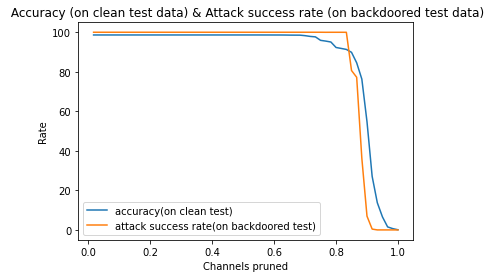

In [31]:
# the x axiel is actually from 1 to 60 and divide 60
x_axis = np.arange(1,61)/60
plt.title(" Accuracy (on clean test data) & Attack success rate (on backdoored test data)")
plt.xlabel("Channels pruned")
plt.ylabel("Rate")
plt.plot(x_axis,acc_test)
plt.plot(x_axis,atk_test)
plt.legend(['accuracy(on clean test)','attack success rate(on backdoored test)'])

As **Lab3 report** and **readme file**, please read 
```c
'./README.md' 
```